# 1. module import 

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import dlib

# 2. image import

In [2]:
img_path = '/aiffel/aiffel/camera_sticker/images/IMG_2181.jpg'
img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()

# 3. image check

(2878, 1851, 3)


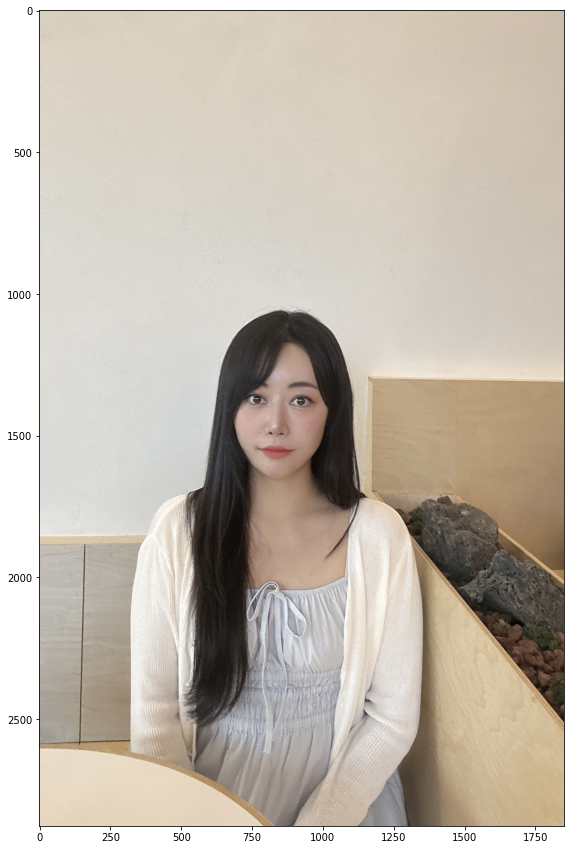

In [3]:
print(img_copy.shape)
plt.figure(figsize=(15, 15))
plt.imshow(img_copy)

# 4. use dlib

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() 
print('using dlib detector_hog')

dlib_rects = detector_hog(img_copy, 1)
print('dlib_rects', dlib_rects)

using dlib detector_hog
dlib_rects rectangles[[(632, 1274) (1017, 1660)]]


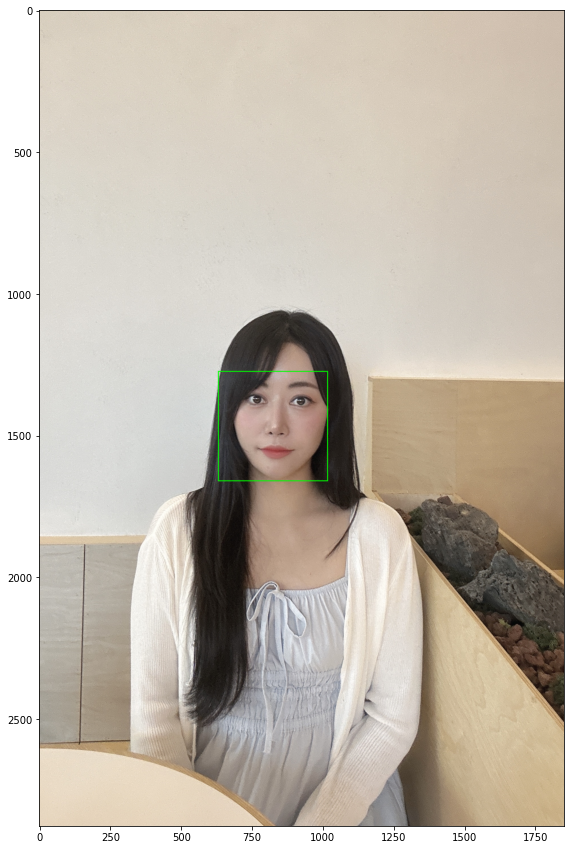

In [5]:
# bbox check
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_copy, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.figure(figsize=(15, 15))
plt.imshow(img_copy)

In [6]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('dlib landmark_predictor')

dlib landmark_predictor


In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


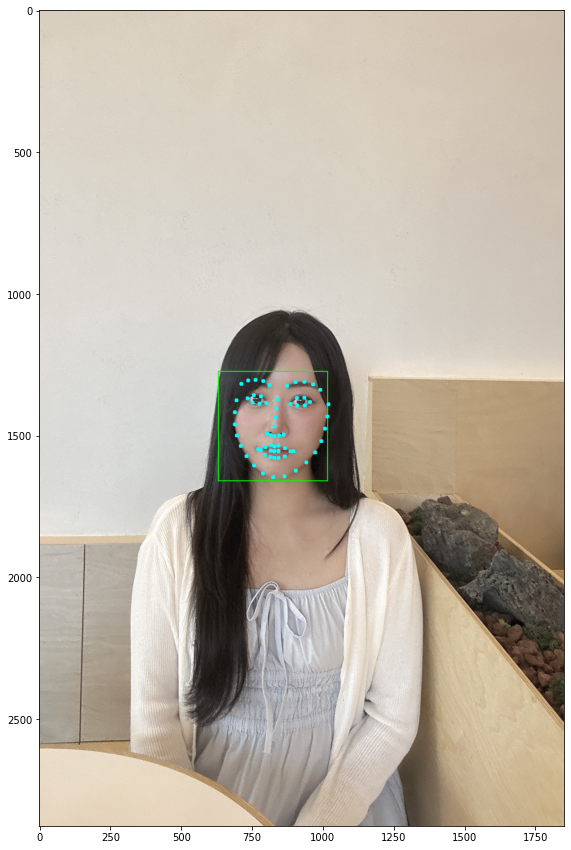

In [8]:
# landmark check
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
#         cv2.circle(img, point, 2, (0, 255, 255), -1)
        # 잘안보여서 thic
        cv2.circle(img_copy, point, 2, (0, 255, 255), 10)
        
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

plt.figure(figsize=(15, 15))
plt.imshow(img_copy)

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(829, 1468)
(x,y) : (829,1275)
(w,h) : (386,386)


# 5. sticker image

In [10]:
# 스티커 이미지 불러오기 + 사이즈 변경
sticker_path = '/aiffel/aiffel/camera_sticker/images/cat-whiskers.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(386, 386, 3)


In [12]:
refined_x = x - w // 2 # 437 - (187//2) = 437-93 = 344
refined_y = y # 89-187 = -98
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

'''
(829, 1468)
(x,y) : (829,1275)
(w,h) : (386,386)
'''

(x,y) : (636,1275)


'\n(829, 1468)\n(x,y) : (829,1275)\n(w,h) : (386,386)\n'

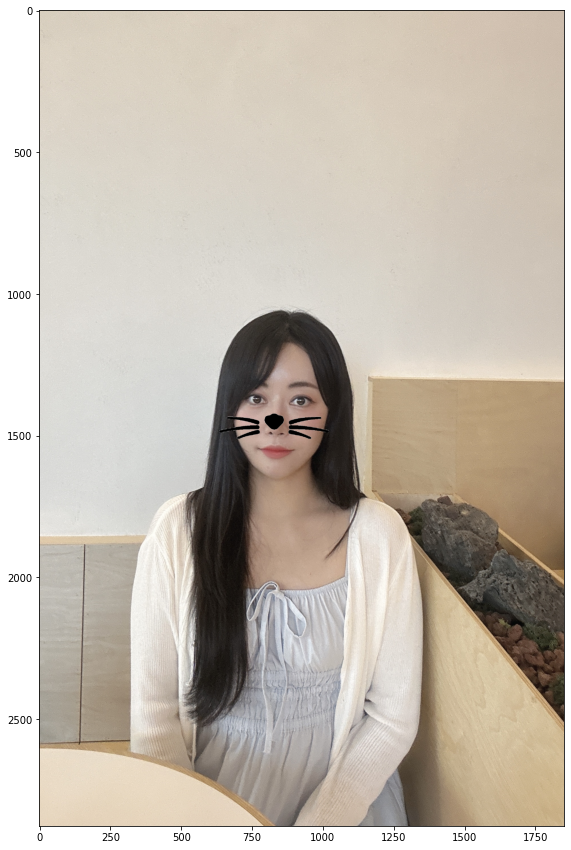

In [13]:
# 스티커가 놓일 영역 지정 (refined_y와 refined_x는 좌표)
sticker_area = img[refined_y:refined_y + img_sticker.shape[0], 
                   refined_x:refined_x + img_sticker.shape[1]]

# 스티커의 흰색이 아닌 부분만 배경에 합성
result = np.where(img_sticker == 0, sticker_area, img_sticker)

# 합성: 검은색 부분만 남기고, 나머지는 원본 이미지의 해당 영역 유지
img[refined_y:refined_y +img_sticker.shape[0], 
    refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
#     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.figure(figsize=(15, 15))
plt.imshow(img)

# 6. 함수화 & 추가실험

(2160, 2160, 3)
(2880, 2160, 3)
(2878, 1851, 3)
(2880, 2160, 3)
(2880, 2160, 3)


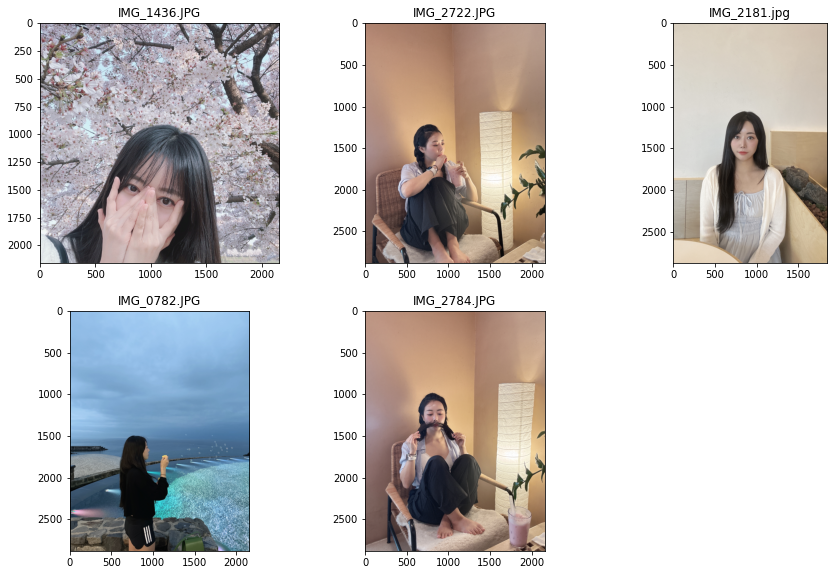

In [14]:
import glob

test_imgs = glob.glob('/aiffel/aiffel/camera_sticker/images/test_imgs/*')

test_img_list = []
fig = plt.figure(figsize=(15,15))
idx = 1

for test in test_imgs:
    img_name = test.split('/')[-1]
    
    test_img = cv2.cvtColor(cv2.imread(test), cv2.COLOR_BGR2RGB)
    print(test_img.shape)

    plt.subplot(3,3,idx)
    plt.title(img_name)
    plt.imshow(test_img)
    idx+=1
    
    test_img_copy = test_img.copy()
    test_img_list.append(test_img_copy)
        
plt.show()

idx 0
dlib_rects rectangles[[(514, 1313) (1313, 2112)]]
list_points 68
idx 1
dlib_rects rectangles[[(735, 1360) (1003, 1628)]]
list_points 68
idx 2
dlib_rects rectangles[[(632, 1274) (1017, 1660)]]
list_points 68
idx 3
dlib_rects rectangles[]
idx 4
dlib_rects rectangles[[(706, 1152) (973, 1420)]]
list_points 68


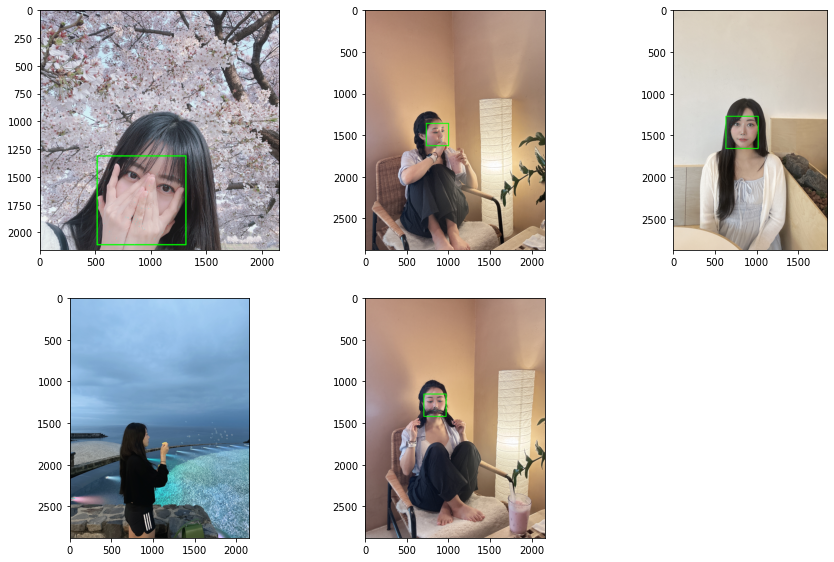

In [15]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector() 

dlib_rect_list =[]
dlib_landmark_list = []

fig = plt.figure(figsize=(15,15))

# 한 이미지에 bbox + landmark
for idx, test_img in enumerate(test_img_list):
    print('idx', idx)
    
    # bbox
    dlib_rects = detector_hog(test_img, 1)
    # dlib_rects rectangles[] => bbox 탐지 못한거
    print('dlib_rects', dlib_rects)
    dlib_rect_list.append(dlib_rects)
    
    # 찾은 얼굴 영역의 좌표
    for dlib_rect in dlib_rects: 
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
        
        # bbox 그리기 
        cv2.rectangle(test_img, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)
        
        #landmark
        points = landmark_predictor(test_img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        print('list_points', len(list_points))
        dlib_landmark_list.append(list_points)
        
        # landmark 그리기
        for point in list_points:
            cv2.circle(test_img, point, 2, (0, 255, 255), -1)        
        
    plt.subplot(3,3,idx+1)
    plt.imshow(test_img)
    idx+=1
        
plt.show()

# 7. 회고

In [ ]:
'''
오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
-> image alignment 필요

멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
-> 멀리서 촬영할 경우에도 화질을 높여서 랜드마크가 잘 보이게 한다거나 
    랜드마크를 윤곽선까지 탐지하는 걸로 변경하거나
    모델 변경하는 방법등으로 탐지 가능
    
실행 속도가 중요할까요?
-> 실시간 앱일 경우 중요, 
따라서 ROI영역으로 범위 축소 하고 난 후 랜드마크 탐지도 속도개선에 좋을 것 같습니다

스티커앱을 만들 때 정확도가 얼마나 중요할까요?
-> threshold로 정확도 지정해야 할텐데
threshold 값을 너무 높이면 얼굴 탐지 자체가 불가능하여
랜드마크 탐지가 어려울 수 있어서 적절한 중간점을 찾아야 합니다


# 추가로 생각해봐야 할 점 #
dlib.get_frontal_face_detector을 반복해서 실행하면 
bbox를 더 못 잡는다. 이거 왜였지..
-> 한번이라도 했던 건 reset 해줘야한다

idx 3
dlib_rects rectangles[]
-> bbox X == landmark X

'''